In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

Use ML env

In [2]:
from hospital import *

In [3]:
hh = hosp('hh')

----------------------------------------
Created hosp class instance:  hh
----------------------------------------
--------------------
Patient fileload: 
--------------------
Found:  hhEDpat.pkl
Missing:  hhIPpat.pkl
--------------------
Daily fileload: 
--------------------
Missing:  hhEDday.pkl
Missing:  hhIPday.pkl


In [4]:
df = hh.pat.get_ED()

In [5]:
ts = df.groupby('arrive_date').count()['hosp_patid']

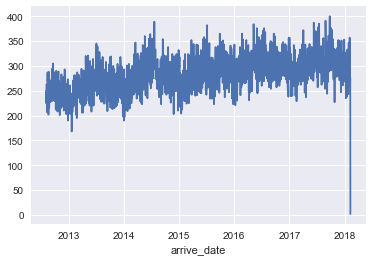

In [6]:
ts.plot()

In [7]:
pd.to_datetime(ts.index)

DatetimeIndex(['2012-08-01', '2012-08-02', '2012-08-03', '2012-08-04',
               '2012-08-05', '2012-08-06', '2012-08-07', '2012-08-08',
               '2012-08-09', '2012-08-10',
               ...
               '2018-01-31', '2018-02-01', '2018-02-02', '2018-02-03',
               '2018-02-04', '2018-02-05', '2018-02-06', '2018-02-07',
               '2018-02-08', '2018-02-09'],
              dtype='datetime64[ns]', name='arrive_date', length=2019, freq=None)

In [8]:
ts = ts.reset_index(level=0)

In [9]:
ts.dtypes

arrive_date    object
hosp_patid      int64
dtype: object

In [10]:
ts = ts[:-1]

In [11]:
ts.arrive_date = pd.to_datetime(ts.arrive_date)

In [12]:
ts['year'] = ts.arrive_date.apply(lambda x : x.year)

In [13]:
ts['month'] = ts.arrive_date.apply(lambda x : x.month)

In [14]:
month_descr = ts.groupby(['year','month']).describe().reset_index()

In [15]:
month_descr.head()

year month hosp_patid                                                       \
                   count        mean        std    min     25%    50%     75%   
0  2012     8       31.0  242.580645  22.855742  202.0  227.00  240.0  253.00   
1  2012     9       30.0  253.833333  20.299623  229.0  240.00  247.5  268.50   
2  2012    10       31.0  243.161290  26.604632  201.0  218.50  238.0  264.50   
3  2012    11       30.0  242.300000  20.027825  210.0  226.25  241.0  254.25   
4  2012    12       31.0  234.483871  25.409803  190.0  219.50  225.0  251.00   

          
     max  
0  288.0  
1  305.0  
2  290.0  
3  283.0  
4  293.0

In [16]:
month_descr['hosp_patid'].columns = list(month_descr.columns.levels[1])[:-1]

In [17]:
month_descr.head()

year month hosp_patid                                                       \
                   count        mean        std    min     25%    50%     75%   
0  2012     8       31.0  242.580645  22.855742  202.0  227.00  240.0  253.00   
1  2012     9       30.0  253.833333  20.299623  229.0  240.00  247.5  268.50   
2  2012    10       31.0  243.161290  26.604632  201.0  218.50  238.0  264.50   
3  2012    11       30.0  242.300000  20.027825  210.0  226.25  241.0  254.25   
4  2012    12       31.0  234.483871  25.409803  190.0  219.50  225.0  251.00   

          
     max  
0  288.0  
1  305.0  
2  290.0  
3  283.0  
4  293.0

In [18]:
col_names = ['year','month'] + list(month_descr.columns.levels[1])[:-1]

In [19]:
month_descr = pd.DataFrame(month_descr.as_matrix(),columns=col_names)

In [20]:
ts = ts.merge(month_descr,on = ['year','month'])

In [21]:
ts.rename(columns={'hosp_patid':'patient_count'},inplace=True)

In [22]:
ts.set_index('arrive_date',inplace=True)

In [23]:
ts.head()

,patient_count,year,month,count,mean,std,min,25%,50%,75%,max
arrive_date,,,,,,,,,,,
2012-08-01,249,2012,8,31.0,242.580645,22.855742,202.0,227.0,240.0,253.0,288.0
2012-08-02,225,2012,8,31.0,242.580645,22.855742,202.0,227.0,240.0,253.0,288.0
2012-08-03,241,2012,8,31.0,242.580645,22.855742,202.0,227.0,240.0,253.0,288.0
2012-08-04,240,2012,8,31.0,242.580645,22.855742,202.0,227.0,240.0,253.0,288.0
2012-08-05,263,2012,8,31.0,242.580645,22.855742,202.0,227.0,240.0,253.0,288.0


#### calc sdev flag

In [24]:
ts['flag_sd'] = 0

In [25]:
ts.loc[ts[ts.patient_count >= ts['50%'] + 1.2*ts['std']].index,'flag_sd'] = 1

In [26]:
ts.flag_sd.value_counts()

0    1728
1     290
Name: flag_sd, dtype: int64

In [27]:
print('Percentage of flagged: ' + str(100*ts.flag_sd.value_counts().values[1]/ts.shape[0]) )

Percentage of flagged: 14.3706640238


#### calc rolling worst prev 5 days in month?

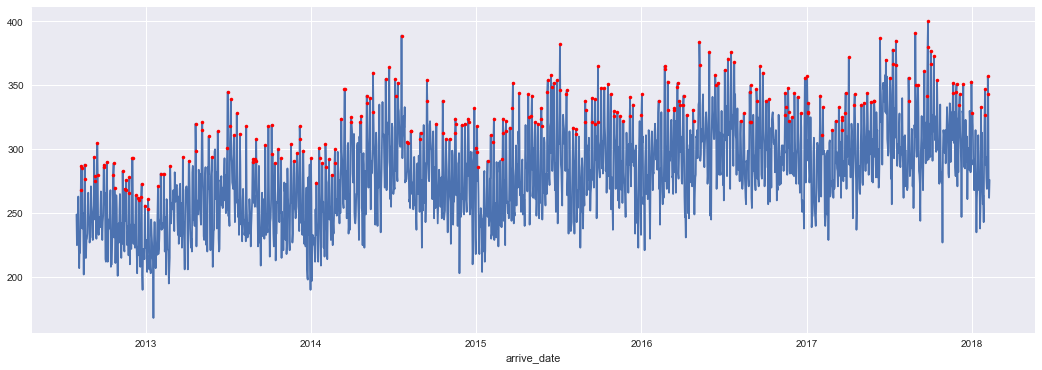

In [28]:
ax = plt.subplot()
ts['patient_count'].plot(ax=ax,figsize=(18,6))

ts[ts.flag_sd == 1]['patient_count'].plot(ax=ax,style='.r')

C:\Anaconda3\envs\ml\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


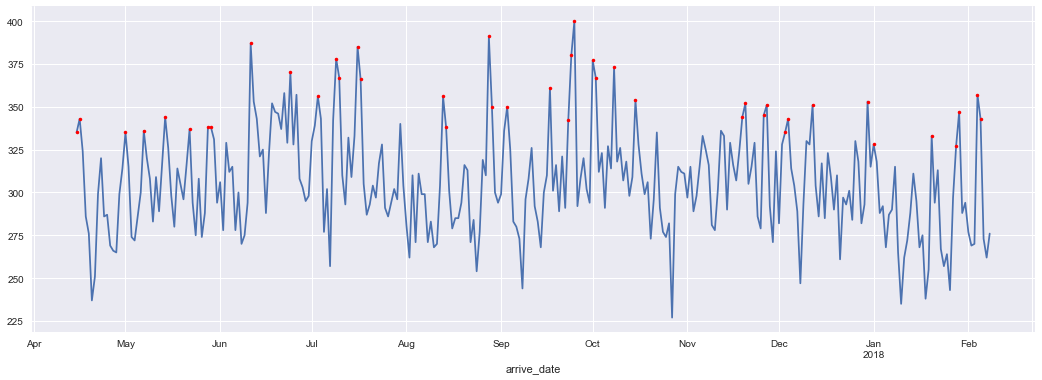

In [29]:
ax = plt.subplot()
ts[-300:]['patient_count'].plot(ax=ax,figsize=(18,6))

ts[-300:][ts.flag_sd == 1]['patient_count'].plot(ax=ax,style='.r')

# Create features

## prepare dfs

In [30]:
days_df = ts.reset_index()

In [31]:
days_df.sample()

,arrive_date,patient_count,year,month,count,mean,std,min,25%,50%,75%,max,flag_sd
1678,2017-03-06,289,2017,3,31.0,295.258065,21.625552,262.0,279.0,289.0,309.5,344.0,0


In [32]:
days_df2 = days_df[['arrive_date','flag_sd']]#.reset_index()

In [33]:
#days_df2.rename(columns={'index':'day_index'},inplace=True)

In [34]:
days_df2.head(1)

,arrive_date,flag_sd
0,2012-08-01,0


In [35]:
pat

hospital.pat

In [36]:
atten_df = hh.pat.get_ED()

In [37]:
atten_df = atten_df.reset_index()

In [38]:
atten_df.head(1)

,index,hosp_patid,age,gender,site,arrive_datetime,arrive_mode,first_triage_datetime,first_dr_datetime,first_adm_request_time,...,depart_weekday_name,depart_year,depart_date,first_adm_request_datetime,arr_triage_wait,arr_dr_wait,arr_adm_req_wait,adm_req_dep_wait,dr_adm_req_wait,dr_dep_wait
0,0,489709,43,Female,BNHH,2012-08-01 00:04:00,2.0,2012-08-01 00:18:00,2012-08-01 02:24:00,NaN,...,Wednesday,2012,2012-08-01,NaT,14.0,140.0,NaN,NaN,NaN,80.0


In [39]:
atten_df2 = atten_df[['hosp_patid',"age","gender",'arrive_datetime','arrive_mode','arrive_date']]

In [40]:
atten_df2.gender.value_counts()

Male             286116
Female           281480
Not Specified        31
Name: gender, dtype: int64

In [41]:
atten_df2.loc[atten_df2['gender'] == 'Male', 'gender'] = 0
atten_df2.loc[atten_df2['gender'] == 'Female', 'gender'] = 1
atten_df2.loc[atten_df2['gender'] == 'Not Specified', 'gender'] = 2

C:\Anaconda3\envs\ml\lib\site-packages\pandas\core\indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


### encoder throws error for some reason
from sklearn import preprocessing

le = preprocessing.LabelEncoder()

le.fit(['m','f'])

le.fit(atten_df2.gender.values)

## create entity set

make set smaller

In [42]:
cutoff = '2017-1-1'

In [43]:
atten_df2 = atten_df2[atten_df2.arrive_datetime > cutoff]

In [44]:
days_df2 = days_df2[days_df2.arrive_date > cutoff]

In [45]:
import featuretools as ft
#import utils
#from utils import load_nyc_taxi_data, compute_features, preview, feature_importances
#from sklearn.ensemble import GradientBoostingRegressor
from featuretools.primitives import (Weekend, Minute, Hour, Day, Week, Month,
                                     Weekday, Weekend, Count, Sum, Mean, Median, Std, Min, Max)

In [112]:
es = ft.EntitySet(id="activity")

In [113]:
atten_df2.head(1)

,hosp_patid,age,gender,arrive_datetime,arrive_mode,arrive_date
246703,2997007,53,1,2017-01-01 00:06:00,1.0,2017-01-01


In [114]:
es.entity_from_dataframe(entity_id="attendances",
                        dataframe=atten_df2,
                         index="index",
                         time_index="arrive_datetime",
                         variable_types={"gender": ft.variable_types.Categorical,
                                        "arrive_mode":ft.variable_types.Categorical}
                        )

2018-04-17 09:59:45,078 featuretools.entityset - WARNING    index index not found in dataframe, creating new integer column


Entityset: activity
  Entities:
    attendances (shape = [122089, 7])
  Relationships:
    No relationships

In [115]:
es["attendances"].variables

[<Variable: hosp_patid (dtype = numeric, count = 122089)>,
 <Variable: age (dtype = numeric, count = 122089)>,
 <Variable: arrive_datetime (dtype: datetime_time_index, format: None)>,
 <Variable: arrive_date (dtype: datetime, format: None)>,
 <Variable: gender (dtype = categorical, count = 122087)>,
 <Variable: arrive_mode (dtype = categorical, count = 121050)>,
 <Variable: index (dtype = index, count = 122089)>]

In [126]:
es = es.entity_from_dataframe(entity_id="days",
                              dataframe=days_df2,
                              index="arrive_date",
                              time_index="arrive_date",
                              variable_types={"flag_sd": ft.variable_types.Categorical}
                             )

In [127]:
days_df2.head()

,arrive_date,flag_sd
1615,2017-01-02,1
1616,2017-01-03,1
1617,2017-01-04,1
1618,2017-01-05,0
1619,2017-01-06,0


In [128]:
es["days"].variables

[<Variable: flag_sd (dtype = categorical, count = 403)>,
 <Variable: arrive_date (dtype: datetime_time_index, format: None)>]

In [129]:
es

Entityset: activity
  Entities:
    attendances (shape = [122089, 7])
    days (shape = [403, 2])
  Relationships:
    No relationships

Add relationhips

In [130]:
new_relationship = ft.Relationship(es["days"]["arrive_date"],
                                  es["attendances"]["arrive_date"])

In [131]:
es = es.add_relationship(new_relationship)

In [132]:
es

Entityset: activity
  Entities:
    attendances (shape = [122089, 7])
    days (shape = [403, 2])
  Relationships:
    attendances.arrive_date -> days.arrive_date

create 'patient' entity

In [133]:
es = es.normalize_entity(base_entity_id="attendances",new_entity_id="patients",index="hosp_patid",
                    additional_variables=["age","gender"])

In [134]:
es

Entityset: activity
  Entities:
    attendances (shape = [122089, 5])
    days (shape = [403, 2])
    patients (shape = [88891, 4])
  Relationships:
    attendances.arrive_date -> days.arrive_date
    attendances.hosp_patid -> patients.hosp_patid

In [135]:
es["patients"].variables

[<Variable: hosp_patid (dtype = index, count = 88891)>,
 <Variable: age (dtype = numeric, count = 88891)>,
 <Variable: gender (dtype = categorical, count = 88889)>,
 <Variable: first_attendances_time (dtype: datetime_time_index, format: None)>]

In [136]:
es["attendances"].variables

[<Variable: hosp_patid (dtype = id, count = 122089)>,
 <Variable: arrive_datetime (dtype: datetime_time_index, format: None)>,
 <Variable: arrive_date (dtype = id, count = 122089)>,
 <Variable: arrive_mode (dtype = categorical, count = 121050)>,
 <Variable: index (dtype = index, count = 122089)>]

In [137]:
es["days"].variables

[<Variable: flag_sd (dtype = categorical, count = 403)>,
 <Variable: arrive_date (dtype = index, count = 403)>]

### make cuttoffs

In [138]:
cutoff = pd.DataFrame(days_df2['arrive_date'])

In [139]:
cutoff['time'] = pd.to_datetime(cutoff.arrive_date + pd.DateOffset(n=-1))

In [144]:
cutoff['time'] = pd.to_datetime(cutoff.arrive_date.apply(lambda x: x.replace(hour=7)))

In [145]:
cutoff.head()

,arrive_date,time
1615,2017-01-02,2017-01-02 07:00:00
1616,2017-01-03,2017-01-03 07:00:00
1617,2017-01-04,2017-01-04 07:00:00
1618,2017-01-05,2017-01-05 07:00:00
1619,2017-01-06,2017-01-06 07:00:00


can specify hour we want to know using...

pd.to_datetime(days_df2.arrive_date).apply(lambda x: x.replace(hour=0)) # .apply(lam) #+ pd.DateOffset(n=-1)

ft.make_temporal_cutoffs(cutoffs['customer_id'],
cutoffs['cutoff_time'],
window_size='3d',
 num_windows=2)

### Create feature matrix

In [160]:
feature_matrix, feature_defs = ft.dfs(entityset=es,
                                      target_entity="days",
                                      cutoff_time=cutoff,
                                      training_window="1 hour",
                                     max_depth=1)
                                     #cutoff_time

2018-04-17 10:28:28,474 featuretools.entityset - WARNING    Using training_window but last_time_index is not set on entity days
2018-04-17 10:28:28,542 featuretools.entityset - WARNING    Using training_window but last_time_index is not set on entity days
2018-04-17 10:28:28,597 featuretools.entityset - WARNING    Using training_window but last_time_index is not set on entity days
2018-04-17 10:28:28,657 featuretools.entityset - WARNING    Using training_window but last_time_index is not set on entity days
2018-04-17 10:28:28,711 featuretools.entityset - WARNING    Using training_window but last_time_index is not set on entity days
2018-04-17 10:28:28,773 featuretools.entityset - WARNING    Using training_window but last_time_index is not set on entity days
2018-04-17 10:28:28,835 featuretools.entityset - WARNING    Using training_window but last_time_index is not set on entity days
2018-04-17 10:28:28,893 featuretools.entityset - WARNING    Using training_window but last_time_index is

2018-04-17 10:28:32,366 featuretools.entityset - WARNING    Using training_window but last_time_index is not set on entity days
2018-04-17 10:28:32,426 featuretools.entityset - WARNING    Using training_window but last_time_index is not set on entity days
2018-04-17 10:28:32,489 featuretools.entityset - WARNING    Using training_window but last_time_index is not set on entity days
2018-04-17 10:28:32,548 featuretools.entityset - WARNING    Using training_window but last_time_index is not set on entity days
2018-04-17 10:28:32,606 featuretools.entityset - WARNING    Using training_window but last_time_index is not set on entity days
2018-04-17 10:28:32,666 featuretools.entityset - WARNING    Using training_window but last_time_index is not set on entity days
2018-04-17 10:28:32,726 featuretools.entityset - WARNING    Using training_window but last_time_index is not set on entity days
2018-04-17 10:28:32,789 featuretools.entityset - WARNING    Using training_window but last_time_index is

2018-04-17 10:28:36,241 featuretools.entityset - WARNING    Using training_window but last_time_index is not set on entity days
2018-04-17 10:28:36,292 featuretools.entityset - WARNING    Using training_window but last_time_index is not set on entity days
2018-04-17 10:28:36,358 featuretools.entityset - WARNING    Using training_window but last_time_index is not set on entity days
2018-04-17 10:28:36,421 featuretools.entityset - WARNING    Using training_window but last_time_index is not set on entity days
2018-04-17 10:28:36,474 featuretools.entityset - WARNING    Using training_window but last_time_index is not set on entity days
2018-04-17 10:28:36,539 featuretools.entityset - WARNING    Using training_window but last_time_index is not set on entity days
2018-04-17 10:28:36,604 featuretools.entityset - WARNING    Using training_window but last_time_index is not set on entity days
2018-04-17 10:28:36,662 featuretools.entityset - WARNING    Using training_window but last_time_index is

2018-04-17 10:28:40,152 featuretools.entityset - WARNING    Using training_window but last_time_index is not set on entity days
2018-04-17 10:28:40,210 featuretools.entityset - WARNING    Using training_window but last_time_index is not set on entity days
2018-04-17 10:28:40,271 featuretools.entityset - WARNING    Using training_window but last_time_index is not set on entity days
2018-04-17 10:28:40,332 featuretools.entityset - WARNING    Using training_window but last_time_index is not set on entity days
2018-04-17 10:28:40,392 featuretools.entityset - WARNING    Using training_window but last_time_index is not set on entity days
2018-04-17 10:28:40,452 featuretools.entityset - WARNING    Using training_window but last_time_index is not set on entity days
2018-04-17 10:28:40,513 featuretools.entityset - WARNING    Using training_window but last_time_index is not set on entity days
2018-04-17 10:28:40,572 featuretools.entityset - WARNING    Using training_window but last_time_index is

2018-04-17 10:28:44,045 featuretools.entityset - WARNING    Using training_window but last_time_index is not set on entity days
2018-04-17 10:28:44,107 featuretools.entityset - WARNING    Using training_window but last_time_index is not set on entity days
2018-04-17 10:28:44,172 featuretools.entityset - WARNING    Using training_window but last_time_index is not set on entity days
2018-04-17 10:28:44,238 featuretools.entityset - WARNING    Using training_window but last_time_index is not set on entity days
2018-04-17 10:28:44,299 featuretools.entityset - WARNING    Using training_window but last_time_index is not set on entity days
2018-04-17 10:28:44,362 featuretools.entityset - WARNING    Using training_window but last_time_index is not set on entity days
2018-04-17 10:28:44,419 featuretools.entityset - WARNING    Using training_window but last_time_index is not set on entity days
2018-04-17 10:28:44,481 featuretools.entityset - WARNING    Using training_window but last_time_index is

2018-04-17 10:28:47,940 featuretools.entityset - WARNING    Using training_window but last_time_index is not set on entity days
2018-04-17 10:28:48,003 featuretools.entityset - WARNING    Using training_window but last_time_index is not set on entity days
2018-04-17 10:28:48,062 featuretools.entityset - WARNING    Using training_window but last_time_index is not set on entity days
2018-04-17 10:28:48,124 featuretools.entityset - WARNING    Using training_window but last_time_index is not set on entity days
2018-04-17 10:28:48,182 featuretools.entityset - WARNING    Using training_window but last_time_index is not set on entity days
2018-04-17 10:28:48,246 featuretools.entityset - WARNING    Using training_window but last_time_index is not set on entity days
2018-04-17 10:28:48,306 featuretools.entityset - WARNING    Using training_window but last_time_index is not set on entity days
2018-04-17 10:28:48,358 featuretools.entityset - WARNING    Using training_window but last_time_index is

2018-04-17 10:28:51,879 featuretools.entityset - WARNING    Using training_window but last_time_index is not set on entity days
2018-04-17 10:28:51,939 featuretools.entityset - WARNING    Using training_window but last_time_index is not set on entity days
2018-04-17 10:28:51,999 featuretools.entityset - WARNING    Using training_window but last_time_index is not set on entity days
2018-04-17 10:28:52,054 featuretools.entityset - WARNING    Using training_window but last_time_index is not set on entity days
2018-04-17 10:28:52,116 featuretools.entityset - WARNING    Using training_window but last_time_index is not set on entity days
2018-04-17 10:28:52,178 featuretools.entityset - WARNING    Using training_window but last_time_index is not set on entity days
2018-04-17 10:28:52,241 featuretools.entityset - WARNING    Using training_window but last_time_index is not set on entity days
2018-04-17 10:28:52,303 featuretools.entityset - WARNING    Using training_window but last_time_index is

feature_matrix, feature_defs = ft.dfs(entityset=es,target_entity="days",cutoff_time=cutoff) #cutoff_time

In [161]:
feature_defs

[<Feature: flag_sd>,
 <Feature: COUNT(attendances)>,
 <Feature: NUM_UNIQUE(attendances.hosp_patid)>,
 <Feature: NUM_UNIQUE(attendances.arrive_mode)>,
 <Feature: MODE(attendances.hosp_patid)>,
 <Feature: MODE(attendances.arrive_mode)>]

In [152]:
feature_defs

[<Feature: flag_sd>,
 <Feature: COUNT(attendances)>,
 <Feature: NUM_UNIQUE(attendances.hosp_patid)>,
 <Feature: NUM_UNIQUE(attendances.arrive_mode)>,
 <Feature: MODE(attendances.hosp_patid)>,
 <Feature: MODE(attendances.arrive_mode)>]

In [162]:
feature_matrix.head(5)

,flag_sd,COUNT(attendances),NUM_UNIQUE(attendances.hosp_patid),NUM_UNIQUE(attendances.arrive_mode),MODE(attendances.hosp_patid),MODE(attendances.arrive_mode)
arrive_date,,,,,,
2017-01-02,NaN,0,NaN,NaN,NaN,NaN
2017-01-03,NaN,0,NaN,NaN,NaN,NaN
2017-01-04,NaN,0,NaN,NaN,NaN,NaN
2017-01-05,NaN,0,NaN,NaN,NaN,NaN
2017-01-06,NaN,0,NaN,NaN,NaN,NaN


In [153]:
feature_matrix.head(20)

,flag_sd,COUNT(attendances),NUM_UNIQUE(attendances.hosp_patid),NUM_UNIQUE(attendances.arrive_mode),MODE(attendances.hosp_patid),MODE(attendances.arrive_mode)
arrive_date,,,,,,
2017-01-02,1,34,34,2.0,106989,1.0
2017-01-03,1,36,36,2.0,6322,2.0
2017-01-04,1,39,39,2.0,4681,2.0
2017-01-05,0,36,36,2.0,21931,1.0
2017-01-06,0,28,28,2.0,8589,1.0
2017-01-07,0,43,43,2.0,9925,1.0
2017-01-08,0,38,38,2.0,8252,1.0
2017-01-09,0,39,39,2.0,23849,1.0
2017-01-10,0,26,26,2.0,5762,1.0


In [150]:
feature_matrix.head(20)

,flag_sd,COUNT(attendances),NUM_UNIQUE(attendances.hosp_patid),NUM_UNIQUE(attendances.arrive_mode),MODE(attendances.hosp_patid),MODE(attendances.arrive_mode)
arrive_date,,,,,,
2017-01-02,1,328,327,2.0,1492907,2.0
2017-01-03,1,329,327,2.0,1503203,2.0
2017-01-04,1,336,335,2.0,795374,2.0
2017-01-05,0,286,284,2.0,968442,2.0
2017-01-06,0,274,271,2.0,96379,2.0
2017-01-07,0,279,275,2.0,299948,2.0
2017-01-08,0,325,324,2.0,967544,2.0
2017-01-09,0,325,324,2.0,928310,2.0
2017-01-10,0,280,279,2.0,330326,2.0


In [67]:
feature_matrix.shape

(403, 6)

In [69]:
feature_matrix.isnull().sum()

flag_sd                                0
COUNT(attendances)                     0
NUM_UNIQUE(attendances.hosp_patid)     0
NUM_UNIQUE(attendances.arrive_mode)    0
MODE(attendances.hosp_patid)           0
MODE(attendances.arrive_mode)          0
dtype: int64

Encode fm

feature_matrix_enc, features_enc = ft.encode_features(feature_matrix, feature_defs)

# Select features

# run test model

test/train split

In [70]:
def split_test_train(data,y_var,test_days):
    """
    Function to take a df (containing y and x vars) and split into X and y; training and testing sets
    NOTE: outputs are in df
    """
    train = data[:-test_days]
    test = data[-test_days:]
    
    
    X_train = train
    y_train = train.pop(y_var)
    X_test = test
    y_test = test.pop(y_var)
    
    return(X_train,y_train,X_test,y_test)

In [71]:
(X_train,y_train,X_test,y_test) = split_test_train(feature_matrix,y_var='flag_sd',test_days=180)

#### scale/encode features??

In [98]:
X_train.head()

,COUNT(attendances),NUM_UNIQUE(attendances.hosp_patid),NUM_UNIQUE(attendances.arrive_mode),MODE(attendances.hosp_patid),MODE(attendances.arrive_mode)
arrive_date,,,,,
2017-01-02,328,327,2.0,1492907,2.0
2017-01-03,329,327,2.0,1503203,2.0
2017-01-04,336,335,2.0,795374,2.0
2017-01-05,286,284,2.0,968442,2.0
2017-01-06,274,271,2.0,96379,2.0


columns_to_encode = ['month','day_of_the_week']
columns_to_scale  = ['ed_atten-1','ed_atten-7','ed_atten','ed_atten-6','ed_atten-2','ed_atten-3','ed_atten-4','ed_atten-5',
                     'ed_adm','pos_virus_perc_t7','pm10_ugm3_t3', 'sulphur_dioxide_ug_m3_t3','air_temp_ave_t7',
                    'air_temp_max']
columns_to_label = []
columns_notchange = ['holiday','year_scaled']

In [ ]:
columns_to_encode = ['month','day_of_the_week']
columns_to_scale  = ['ed_atten-1','ed_atten-7','ed_atten','ed_atten-6','ed_atten-2','ed_atten-3','ed_atten-4','ed_atten-5',
                     'ed_adm','pos_virus_perc_t7','pm10_ugm3_t3', 'sulphur_dioxide_ug_m3_t3','air_temp_ave_t7',
                    'air_temp_max']
columns_to_label = []
columns_notchange = ['holiday','year_scaled']

### run model

In [72]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression()

In [73]:
model = LogisticRegression()
model.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [74]:
pred = model.predict(X_test)

#### alternate model

In [75]:
from sklearn.svm import SVC

In [81]:
SVM = SVC()
#SVM.fit(X_train,y_train)

optimise model hyper params

In [82]:
from sklearn.model_selection import GridSearchCV

In [83]:
param_grid = [{'kernel':['linear','rbf']}]

param_grid = [
    {'kernel':['linear']}, #,'rbf','poly','sigmoid']},
    #{'kernel':['linear'],'epsilon':[10],'C':[0.1,0.15,0.2,0.3,0.5,0.6,1,2,3,4,5]}
    {'kernel':['linear'],'epsilon':[10],'C':[0.5]}
]

  #  {'kernel':['sigmoid'], 'gamma':[0.001,0.01,0.05,0.1,1,2],'epsilon':[0.1,1],'C':[0.2,0.3,0.5,0.6,1,2]},

In [84]:
grid_search = GridSearchCV(SVM,param_grid, cv=3, scoring="f1") #neg_mean_absolute_error neg_mean_squared_error

In [85]:
grid_search.fit(X_train,y_train)

C:\Anaconda3\envs\ml\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Anaconda3\envs\ml\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Anaconda3\envs\ml\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Anaconda3\envs\ml\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


GridSearchCV(cv=3, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'kernel': ['linear', 'rbf']}], pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring='f1', verbose=0)

In [86]:
cvres = grid_search.cv_results_

In [87]:
cvres

C:\Anaconda3\envs\ml\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Anaconda3\envs\ml\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Anaconda3\envs\ml\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Anaconda3\envs\ml\lib\site-packages\sklearn\utils\deprecation.py:1

{'mean_fit_time': array([  2.38361261e+01,   2.67346700e-03]),
 'mean_score_time': array([ 0.00268706,  0.00334247]),
 'mean_test_score': array([ 0.31437338,  0.        ]),
 'mean_train_score': array([ 0.29348659,  1.        ]),
 'param_kernel': masked_array(data = ['linear' 'rbf'],
              mask = [False False],
        fill_value = ?),
 'params': [{'kernel': 'linear'}, {'kernel': 'rbf'}],
 'rank_test_score': array([1, 2]),
 'split0_test_score': array([ 0.,  0.]),
 'split0_train_score': array([ 0.26666667,  1.        ]),
 'split1_test_score': array([ 0.63157895,  0.        ]),
 'split1_train_score': array([ 0.2,  1. ]),
 'split2_test_score': array([ 0.31578947,  0.        ]),
 'split2_train_score': array([ 0.4137931,  1.       ]),
 'std_fit_time': array([  1.72814865e+01,   4.72606701e-04]),
 'std_score_time': array([ 0.00096275,  0.00047266]),
 'std_test_score': array([ 0.25812604,  0.        ]),
 'std_train_score': array([ 0.08931724,  0.        ])}

In [88]:
for mean_score, params in zip(cvres["mean_test_score"],cvres["params"]):
    print(np.sqrt(-mean_score),params)
final_model = grid_search.best_estimator_
#final_model

nan {'kernel': 'linear'}
-0.0 {'kernel': 'rbf'}


In [ ]:
y_pred = final_model.predict(X_trains)
model_mse = mean_squared_error(y_train, y_pred)
model_rmse = np.sqrt(model_mse)

### eval model

In [120]:
y_train_pred = cross_val_predict(model, X_train,y_train,cv=5)

In [124]:
from sklearn.metrics import confusion_matrix

In [128]:
cm = confusion_matrix(y_train,y_train_pred)
cm

array([[1525,   50],
       [ 156,  107]], dtype=int64)

Text(92.68,0.5,'true value')

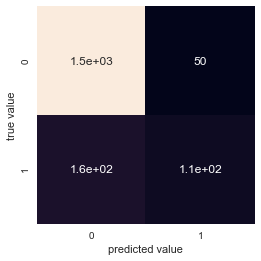

In [127]:
sns.heatmap(cm,square=True,annot=True,cbar=False)
plt.xlabel('predicted value')
plt.ylabel('true value')

In [90]:
from sklearn.model_selection import cross_val_predict

In [91]:
y_scores = cross_val_predict(final_model,X_train,y_train, cv=5,method='decision_function')

In [92]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train,y_scores)

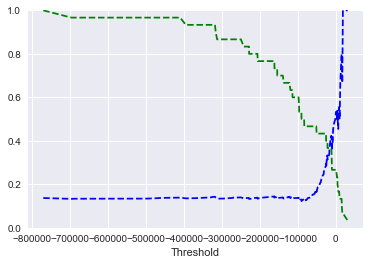

In [93]:
def plot_precision_recall_curve(precisions,recalls,thresholds):
    plt.plot(thresholds, precisions[:-1],'b--',label='precision')
    plt.plot(thresholds,recalls[:-1],'g--',label='recall')
    plt.xlabel("Threshold")
    plt.ylim([0,1])
    
plot_precision_recall_curve(precisions,recalls,thresholds)

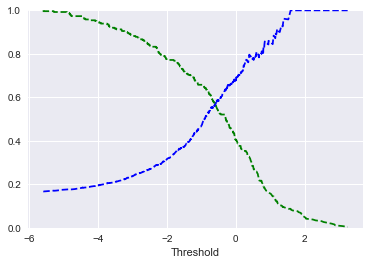

In [137]:
def plot_precision_recall_curve(precisions,recalls,thresholds):
    plt.plot(thresholds, precisions[:-1],'b--',label='precision')
    plt.plot(thresholds,recalls[:-1],'g--',label='recall')
    plt.xlabel("Threshold")
    plt.ylim([0,1])
    
plot_precision_recall_curve(precisions,recalls,thresholds)

In [94]:
from sklearn.metrics import roc_curve

In [95]:
fpr, tpr, thresholds = roc_curve(y_train,y_scores)

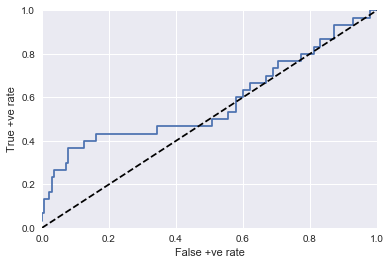

In [96]:
def plot_roc_curve(fpr,tpr,label=None):
    plt.plot(fpr,tpr,label=label)
    plt.plot([0,1],[0,1],'k--')
    plt.axis([0,1,0,1])
    plt.xlabel('False +ve rate')
    plt.ylabel('True +ve rate')
    
plot_roc_curve(fpr,tpr)

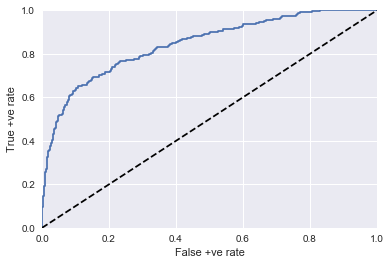

In [151]:
def plot_roc_curve(fpr,tpr,label=None):
    plt.plot(fpr,tpr,label=label)
    plt.plot([0,1],[0,1],'k--')
    plt.axis([0,1,0,1])
    plt.xlabel('False +ve rate')
    plt.ylabel('True +ve rate')
    
plot_roc_curve(fpr,tpr)

In [66]:
from sklearn import metrics

In [67]:
metrics.accuracy_score(y_test,pred)

0.94444444444444442

In [68]:
metrics.f1_score(y_test,pred)

0.83870967741935487

In [69]:
mat = metrics.confusion_matrix(y_test,pred)

Text(92.68,0.5,'true value')

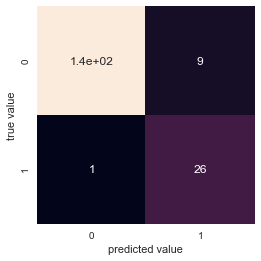

In [70]:
sns.heatmap(mat,square=True,annot=True,cbar=False)
plt.xlabel('predicted value')
plt.ylabel('true value')

In [71]:
36/170

0.21176470588235294

In [72]:
scoring = 'f1'

In [73]:
cross_val_score(model,X_train,y_train,cv=10,scoring='accuracy')

array([ 0.85405405,  0.86486486,  0.85405405,  0.90217391,  0.86956522,
        0.93442623,  0.93442623,  0.86885246,  0.91256831,  0.84699454])

In [74]:
fpr , tpr, threshholds = metrics.roc_curve(y_test,pred)

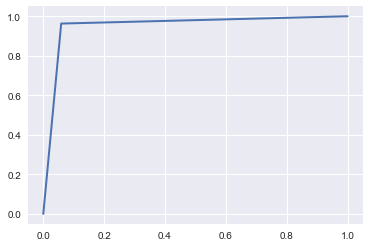

In [75]:
def plot_roc_curve(fpr,tpr,label=None):
    plt.plot(fpr,tpr,linewidth=2,label=label)
    
plot_roc_curve(fpr,tpr)

In [76]:
model

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [77]:
def sk_run_default_models_classifier(X_trains,y_train,scoring="f1"):
    """
    Function runs many sklearn models with default settings and outputs results to a df for quick sorting.
    
    Inputs: 
    X_train : training data features
    y_train : training data labels
    
    scoring : takes values from: http://scikit-learn.org/stable/modules/model_evaluation.html
    For regression:
    ‘explained_variance’ ‘neg_mean_absolute_error’ ‘neg_mean_squared_error’‘neg_mean_squared_log_error’
    ‘neg_median_absolute_error’
    ‘r2’
    """
    
    import pandas as pd
    #     from sklearn.model_selection import cross_val_score
    #     from sklearn.linear_model import LinearRegression
    #     lin_reg = LinearRegression()
    #     from sklearn.linear_model import Lasso
    #     lasso = Lasso()
    #     from sklearn.linear_model import Ridge
    #     ridge = Ridge()
    #     from sklearn.ensemble import RandomForestRegressor
    #     rforest = RandomForestRegressor()
    #     from sklearn.svm import SVR
    #     svm_rbf = SVR()
    #     svm_linear = SVR(kernel='linear')
    #     svm_poly = SVR(kernel='poly')
    #     svm_sigmoid = SVR(kernel='sigmoid')
    #     from sklearn.naive_bayes import GaussianNB
    #     gnb = GaussianNB()
    #     from sklearn.neural_network import MLPRegressor
    #     ann = MLPRegressor()
    from sklearn.model_selection import cross_val_score
    from sklearn.linear_model import LogisticRegression
    log_reg = LogisticRegression()
    
    #models = {'lin_reg':lin_reg, 'lasso':lasso , 'ridge':ridge ,'rforest':rforest ,
    #          'svm_rbf':svm_rbf ,'svm_linear':svm_linear,'svm_poly':svm_poly,'svm_sigmoid':svm_sigmoid, 'gnb': gnb}
    
    models = {'log_reg':log_reg}
    output = pd.DataFrame() # create empty results frame
    
    for model in models.keys():
        print('\n' , model)
        scores = cross_val_score(models[model],X_trains,y_train, scoring=scoring,cv=10)
        rmse_scores = np.sqrt(-scores)
        output = output.append({'model':model ,'RMSE_mean': rmse_scores.mean(),
                                'RMSE_std':rmse_scores.std() ,'RMSE_scores':rmse_scores},ignore_index=True)
    # sort cols and order 
    output = output[['model','RMSE_mean','RMSE_std','RMSE_scores']].sort_values('RMSE_mean').reset_index(drop=True)
    
    
    return(output)


In [78]:
y = sk_run_default_models_regression(X_train,y_train)
y

NameError: name 'sk_run_default_models_regression' is not defined

In [ ]:
scores = cross_val_score(models[model],X_trains,y_train, scoring=scoring,cv=10)

In [ ]:
def sk_run_default_models_regression(X_trains,y_train,scoring="neg_mean_squared_error"):
    """
    Function runs many sklearn models with default settings and outputs results to a df for quick sorting.
    
    Inputs: 
    X_train : training data features
    y_train : training data labels
    
    scoring : takes values from: http://scikit-learn.org/stable/modules/model_evaluation.html
    For regression:
    ‘explained_variance’ ‘neg_mean_absolute_error’ ‘neg_mean_squared_error’‘neg_mean_squared_log_error’
    ‘neg_median_absolute_error’
    ‘r2’
    """
    
    import pandas as pd
    from sklearn.model_selection import cross_val_score
    from sklearn.linear_model import LinearRegression
    lin_reg = LinearRegression()
    from sklearn.linear_model import Lasso
    lasso = Lasso()
    from sklearn.linear_model import Ridge
    ridge = Ridge()
    from sklearn.ensemble import RandomForestRegressor
    rforest = RandomForestRegressor()
    from sklearn.svm import SVR
    svm_rbf = SVR()
    svm_linear = SVR(kernel='linear')
    svm_poly = SVR(kernel='poly')
    svm_sigmoid = SVR(kernel='sigmoid')
    from sklearn.naive_bayes import GaussianNB
    gnb = GaussianNB()
    from sklearn.neural_network import MLPRegressor
    ann = MLPRegressor()
    
    models = {'lin_reg':lin_reg, 'lasso':lasso , 'ridge':ridge ,'rforest':rforest ,
              'svm_rbf':svm_rbf ,'svm_linear':svm_linear,'svm_poly':svm_poly,'svm_sigmoid':svm_sigmoid, 'gnb': gnb}
    output = pd.DataFrame() # create empty results frame
    
    for model in models.keys():
        print('\n' , model)
        scores = cross_val_score(models[model],X_trains,y_train, scoring=scoring,cv=10)
        rmse_scores = np.sqrt(-scores)
        output = output.append({'model':model ,'RMSE_mean': rmse_scores.mean(),
                                'RMSE_std':rmse_scores.std() ,'RMSE_scores':rmse_scores},ignore_index=True)
    # sort cols and order 
    output = output[['model','RMSE_mean','RMSE_std','RMSE_scores']].sort_values('RMSE_mean').reset_index(drop=True)
    
    
    return(output)


# Dev

In [ ]:
break

In [ ]:
atten_df.arrive_date.head()

In [ ]:
entities = {
    "days": (days_df, "arrive_date"),
    "attendances": (atten_df, "hosp_patid",'arrive_date'),
}

relationships = [("days", "arrive_date", "attendances", "arrive_date")]

In [ ]:
trans_primitives = [Weekend]

features = ft.dfs(entities=entities,
                  relationships=relationships,
                  target_entity="days",
                  trans_primitives=trans_primitives,
                  agg_primitives=[],
                  ignore_variables={},
                  features_only=True)

In [ ]:
features

In [104]:
import featuretools as ft

es1 = ft.demo.load_mock_customer(return_entityset=True)

In [33]:
import featuretools as ft

(cust, prod, sess, trans) = ft.demo.load_mock_customer()

In [34]:
cust

'customers'

In [105]:
es1

Entityset: transactions
  Entities:
    transactions (shape = [500, 5])
    products (shape = [5, 2])
    sessions (shape = [35, 4])
    customers (shape = [5, 3])
  Relationships:
    transactions.product_id -> products.product_id
    transactions.session_id -> sessions.session_id
    sessions.customer_id -> customers.customer_id

In [106]:
es1['customers']

Entity: customers
  Variables:
    join_date (dtype: datetime_time_index)
    zip_code (dtype: categorical)
    customer_id (dtype: index)
  Shape:
    (5, 3)

In [107]:
es1['products']

Entity: products
  Variables:
    brand (dtype: categorical)
    product_id (dtype: index)
  Shape:
    (5, 2)

In [108]:
feature_matrix, feature_defs = ft.dfs(entityset=es1,
                                     target_entity="customers",
                                     max_depth=2)

In [109]:
feature_matrix

,zip_code,COUNT(sessions),NUM_UNIQUE(sessions.device),MODE(sessions.device),SUM(transactions.amount),STD(transactions.amount),MAX(transactions.amount),SKEW(transactions.amount),MIN(transactions.amount),MEAN(transactions.amount),...,NUM_UNIQUE(sessions.MODE(transactions.product_id)),NUM_UNIQUE(sessions.DAY(session_start)),NUM_UNIQUE(sessions.YEAR(session_start)),NUM_UNIQUE(sessions.MONTH(session_start)),NUM_UNIQUE(sessions.WEEKDAY(session_start)),MODE(sessions.MODE(transactions.product_id)),MODE(sessions.DAY(session_start)),MODE(sessions.YEAR(session_start)),MODE(sessions.MONTH(session_start)),MODE(sessions.WEEKDAY(session_start))
customer_id,,,,,,,,,,,,,,,,,,,,,
1,60091,10,3,desktop,10236.77,42.673267,149.95,0.070041,5.60,78.143282,...,3,1,1,1,1,1,1,2014,1,2
2,02139,8,3,mobile,9118.81,43.204771,149.15,0.028647,5.81,74.744344,...,5,1,1,1,1,1,1,2014,1,2
3,02139,5,2,desktop,5758.24,40.127924,147.73,0.070814,6.78,73.823590,...,4,1,1,1,1,3,1,2014,1,2
4,60091,8,3,desktop,8205.28,41.857208,149.56,0.087986,5.73,73.921441,...,5,1,1,1,1,1,1,2014,1,2
5,02139,4,3,tablet,4571.37,42.656189,148.17,0.085883,5.91,78.816724,...,3,1,1,1,1,2,1,2014,1,2


In [110]:
feature_defs

[<Feature: zip_code>,
 <Feature: COUNT(sessions)>,
 <Feature: NUM_UNIQUE(sessions.device)>,
 <Feature: MODE(sessions.device)>,
 <Feature: SUM(transactions.amount)>,
 <Feature: STD(transactions.amount)>,
 <Feature: MAX(transactions.amount)>,
 <Feature: SKEW(transactions.amount)>,
 <Feature: MIN(transactions.amount)>,
 <Feature: MEAN(transactions.amount)>,
 <Feature: COUNT(transactions)>,
 <Feature: NUM_UNIQUE(transactions.product_id)>,
 <Feature: MODE(transactions.product_id)>,
 <Feature: DAY(join_date)>,
 <Feature: YEAR(join_date)>,
 <Feature: MONTH(join_date)>,
 <Feature: WEEKDAY(join_date)>,
 <Feature: SUM(sessions.STD(transactions.amount))>,
 <Feature: SUM(sessions.MAX(transactions.amount))>,
 <Feature: SUM(sessions.SKEW(transactions.amount))>,
 <Feature: SUM(sessions.MIN(transactions.amount))>,
 <Feature: SUM(sessions.MEAN(transactions.amount))>,
 <Feature: SUM(sessions.NUM_UNIQUE(transactions.product_id))>,
 <Feature: STD(sessions.SUM(transactions.amount))>,
 <Feature: STD(session

In [167]:
feature_matrix, feature_defs = ft.dfs(entityset=es1,
                                     target_entity="customers",
                                   agg_primitives=["count"], trans_primitives=["month"])

AttributeError: 'str' object has no attribute 'input_types'

In [220]:
feature_defs = ft.dfs(entityset=es1,
                     target_entity="customers",
                   agg_primitives=["count"],
                      trans_primitives=["weekend"],
                     features_only=True)

AttributeError: 'str' object has no attribute 'input_types'